In [32]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [33]:
import os
#图像读取库
from PIL import Image
#矩阵运算库
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [34]:
# 分类
label_names = ["anger", "disgust", "fear", "happy", "sad"]
label_to_index = dict((name, index) for index, name in enumerate(label_names))

print(label_names)
print(label_to_index)

['anger', 'disgust', 'fear', 'happy', 'sad']
{'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4}


In [35]:
# 获取训练的图片列表和分类标签信息
def load_images(data_dir):
    fpaths = []
    labels = []
    
    for label in os.listdir(data_dir):
        labelPath = os.path.join(data_dir, label)
        for fname in os.listdir(labelPath):
            # 文件名
            fpath = os.path.join(labelPath, fname)
            fpaths.append(fpath)
            
            # 标签
            labels.append(label_to_index[label])
    
    # 将图片名和标签 打包成一组，然后进行乱序
    temp = np.array([fpaths,labels])
    temp = temp.transpose()
    np.random.shuffle(temp)

    fpaths = list(temp[:,0])
    labels = list(temp[:,1])
    labels = [int(i) for i in labels]
    
    return fpaths, labels

In [36]:
# 数据文件夹
data_dir = "/home/wilson/workstation/TFResFaceEmotion/emotions"

all_image_paths, all_image_labels = load_images(data_dir)

image_count = len(all_image_paths)
print("total", image_count, "images")

total 79 images


In [37]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image,dtype=tf.float32)
    image /= 255.0
    #print(333, image.shape, image)
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

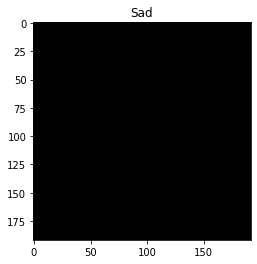

In [38]:
import matplotlib.pyplot as plt

image_path = all_image_paths[0]
label = all_image_labels[0]

plt.imshow(load_and_preprocess_image(image_path))
plt.grid(False)
plt.title(label_names[label].title())
print()

In [39]:
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

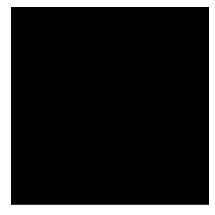

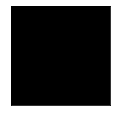

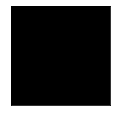

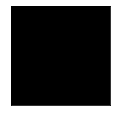

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
for n, image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()


In [41]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

for label in label_ds.take(10):
    print(label_names[label.numpy()])

sad
anger
happy
happy
happy
anger
happy
anger
fear
fear


In [42]:
# 由于这些数据集顺序相同，你可以将他们打包在一起得到一个(图片, 标签)对数据集：
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

# 元组被解压缩到映射函数的位置参数中
def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
image_label_ds = ds.map(load_and_preprocess_from_path_label)
print(image_label_ds)

<ZipDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int32)>


In [43]:
"""训练的基本方法
要使用此数据集训练模型，你将会想要数据：

    被充分打乱。
    被分割为 batch。
    永远重复。
    尽快提供 batch。

使用 tf.data api 可以轻松添加这些功能。
"""
BATCH_SIZE = 32

# 设置一个和数据集大小一致的 shuffle buffer size（随机缓冲区大小）以保证数据
# 被充分打乱。
ds = image_label_ds.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
ds = ds.prefetch(buffer_size=AUTOTUNE)
print(ds)

ds = image_label_ds.apply(
  tf.data.experimental.shuffle_and_repeat(buffer_size=image_count))
ds = ds.batch(BATCH_SIZE)
ds = ds.prefetch(buffer_size=AUTOTUNE)
print(ds)

<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int32)>
<PrefetchDataset shapes: ((None, None, None, 3), (None,)), types: (tf.float32, tf.int32)>


In [44]:
# 现在准备分类模型
mobile_net = tf.keras.applications.MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable=False


In [45]:
# 该模型期望它的输出被标准化至 [-1,1] 范围内：
# help(tf.keras.applications.mobilenet_v2.preprocess_input)


In [46]:
# 在你将输出传递给 MobilNet 模型之前，你需要将其范围从 [0,1] 转化为 [-1,1]：
def change_range(image,label):
    return 2*image-1, label

keras_ds = ds.map(change_range)

# 数据集可能需要几秒来启动，因为要填满其随机缓冲区。
image_batch, label_batch = next(iter(keras_ds))

feature_map_batch = mobile_net(image_batch)
print(feature_map_batch.shape)


(32, 6, 6, 1280)


In [47]:
model = tf.keras.Sequential([
    mobile_net,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(label_names), activation='softmax')])

In [48]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.105850965
max logit: 0.3818455

Shape: (32, 5)


In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])


In [50]:
len(model.trainable_variables)


2

In [51]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [52]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch


3.0

In [53]:
model.fit(ds, epochs=1, steps_per_epoch=3)


3/3 [==============================] - 0s 15ms/step - loss: 1.6127 - accuracy: 0.2604


In [ ]:
# 获取训练的图片列表和分类标签信息
def read_data(data_dir):
    fpaths = []
    datas = []
    labels = []
    
    for label in os.listdir(data_dir):
        labelPath = os.path.join(data_dir, label)
        for fname in os.listdir(labelPath):
            # 文件名
            fpath = os.path.join(labelPath, fname)
            fpaths.append(fpath)
            
            # 图片数据
            image = Image.open(fpath)
            data = np.array(image) / 255.0
            datas.append(data)
            
            # 标签
            labels.append(CATEGORIES[label])
    
    datas = np.array(datas)
    labels = np.array(labels)
    print("shape of datas :", datas.shape)
    print("shape of labels:", labels.shape)
    return fpaths, datas, labels

In [ ]:
fpaths, datas, labels = read_data(data_dir)

# 计算有多少类图片
num_classes = len(set(labels))
print("classes:%d" %num_classes)

In [ ]:
# 定义Placeholder，存放输入和标签
datas_placeholder = tf.compat.v1.placeholder(tf.float32, [None, 32, 32, 3])
labels_placeholder = tf.compat.v1.placeholder(tf.int32, [None])

# 存放DropOut参数的容器，训练时为0.25，测试时为0
dropout_placeholdr = tf.compat.v1.placeholder(tf.float32)

In [ ]:
# 定义卷积层, 20个卷积核, 卷积核大小为5，用Relu激活
conv0 = tf.layers.conv2d(datas_placeholder, 20, 5, activation=tf.nn.relu)
# 定义max-pooling层，pooling窗口为2x2，步长为2x2
pool0 = tf.layers.max_pooling2d(conv0, [2, 2], [2, 2])

# 定义卷积层, 40个卷积核, 卷积核大小为4，用Relu激活
conv1 = tf.layers.conv2d(pool0, 40, 4, activation=tf.nn.relu)
# 定义max-pooling层，pooling窗口为2x2，步长为2x2
pool1 = tf.layers.max_pooling2d(conv1, [2, 2], [2, 2])

In [ ]:
def get_batch(image, label, image_W, image_H, batch_size, capacity):
    image = tf.cast(image, tf.string)
    label = tf.cast(label, tf.int32)
    
    # 加入队列
    # input_queue = tf.train.slice_input_producer([image, label])
    # input_queue = tf.data.Dataset.from_tensor_slices((image, labels))
    input_queue = tf.compat.v1.train.slice_input_producer([image, label])
    
    label = input_queue[1]
    
    # 将图片按照jpeg进行解码
    image_contents = tf.read_file(input_queue[0])
    image = tf.image.decode_jpeg(image_contents, channels=3)
    image = tf.image.resize_image_with_crop_or_pad(image, image_W, image_H)
    image = tf.image.per_image_standerdization(image)
    
    image_batch, label_batch = tf.train.batch([image, label], 
        batch_size = batch_size,
        num_threads = 16,
        capacity = capacity)
    
    label_batch = tf.reshape(label_batch, [batch_size])
    return image_batch, label_batch

In [ ]:
BATCH_SIZE = 5
CAPACITY = 64
IMG_W = 208
IMG_H = 208

# 进行训练的目录
train_dir = "/home/wilson/workstation/TFResFaceEmotion/emotions"

# 获取原始图片信息列表
image_list, label_list = get_files(train_dir)
print("image_list:", len(image_list))
print("label_list:", len(label_list))

image_batch,label_batch = get_batch(image_list,label_list,IMG_W,IMG_H,BATCH_SIZE,CAPACITY)

with tf.Session() as sess:
    i = 0
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord = coord)
    try:
        while not coord.should_stop() and i<2:
            # 提取出2个batch的图片进行可视化
            img, label = sess.run([image_batch, label_batch])
            for j in np.arrange(BATCH_SIZE):
                print('label:%d' %label[j])
                plt.imshow(img[j,:,:,:])
                plt.show()
            i+=1
    except tf.errors.OutOfRangeError:
        print('done!')
    finally:
        coord.request_stop()
    coord.join(threads)